In [1]:
%pylab inline
#sys.path.insert(0, '/home/peter/code/projects/tradesys/')
from pomegranate import *
from tradesys import *
from tradesys.testing import *
import talib as ta
from sklearn.preprocessing import scale
import pandas as pd
import random as rnd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# df = pd.read_csv('Coinbase_BTCUSD_1h.csv')
# nd = []
# for i,(d,o,h,l,c,v) in df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume BTC']].iterrows():
#     ds = d.split(' ')[0].split('-')
#     hs = d.split(' ')[1].split('-')[:-1]
#     ds = [int(x) for x in ds]
#     hs = [int(x) for x in hs]
#     nd.append(ds + hs + [0,0] + [o,h,l,c,v])
# datamatrix = DataMatrix()
# for y,mn,d,hr,m,s, o,h,l,c,v in nd:
#     datamatrix.add_row(DateTime(y,mn,d,hr,m,s), o,h,l,c,int(v))

In [3]:
datamatrix = DataMatrix()
datamatrix.load_multicharts('../deep_learning_trader/data/EURUSD_1_Minute_01_01_2010-10_31_2016.txt')
datamatrix.clip_dt(DateTime(2014,1,1), DateTime(2016,1,1))

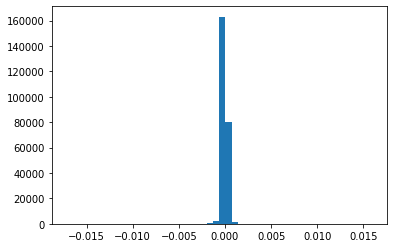

In [4]:
a = np.diff(array(datamatrix.close))
#a = a[where((a > -0.001) & (a < 0.001) & (a != 0))]
hist(a, 50);

In [5]:
# estimate noise distribution of data
w = NormalDistribution.from_samples(a)

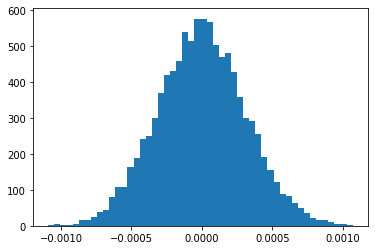

In [6]:
hist([w.sample() for i in range(10000)], 50);

In [7]:
init_price = 100.0
spread = 0.02
ps = []
ps.append(init_price)

# random walk
num_entries = 100000
for i in range(num_entries-1):
    ps.append( ps[-1] + round(w.sample(), 5) )

dti = pd.date_range('2018-01-01', periods=num_entries, freq='Min')

df = pd.DataFrame(data=ps, index=dti, columns=['Bid'])

df = df.resample('5Min').ohlc()
df['volume'] = 200000.0

noise_datamatrix = df2dmat(df)

In [8]:
#dmat2df(datamatrix).head()

In [9]:
#len(datamatrix)

In [10]:
#datamatrix = fill_incomplete_datamatrix(datamatrix)

In [11]:
#dmat2df(datamatrix).head()

In [12]:
len(datamatrix)

248122

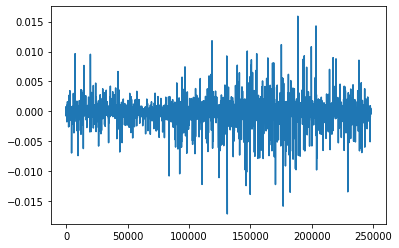

In [13]:
plot( np.diff(array(datamatrix.close)));

In [14]:
#datamatrix.dump_tsys("data.tsys")

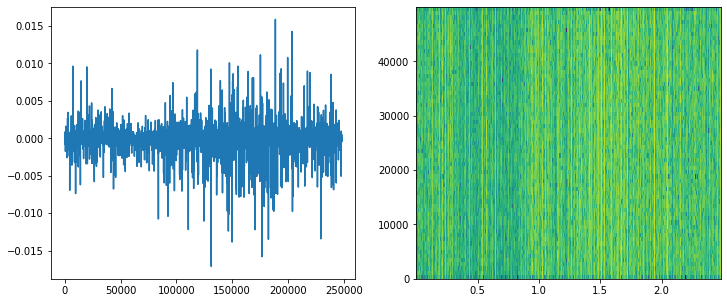

In [15]:
dt = 0.00001
x = np.diff(array(datamatrix.close))

NFFT = 128  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=32)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

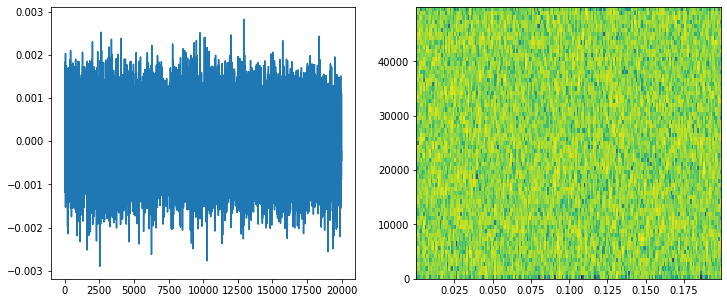

In [16]:
dt = 0.00001
xns = np.diff(array(noise_datamatrix.close))  

NFFT = 128  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(xns)
Pxx, freqs, bins, im = ax2.specgram(xns, NFFT=NFFT, Fs=Fs, noverlap=32)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [17]:
# denoise 

import time
from datetime import timedelta as td
import librosa
import scipy

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

STFT on noise: 0:00:00.049953
STFT on signal: 0:00:00.541342
[-40.406925 -42.81993  -42.71161  -42.65682  -42.000942 -42.14084
 -42.265297 -41.800446 -41.87247  -42.039482 -42.22286  -42.093422
 -42.61284  -41.949566 -42.22216  -42.066204 -42.465443 -42.662563
 -42.552986 -42.311295 -42.395447 -42.008156 -42.044582 -42.16454
 -42.15122  -42.039036 -41.858246 -42.132133 -42.056137 -42.034847
 -42.31457  -41.790184 -41.453583 -41.504326 -41.993862 -42.284344
 -42.360447 -42.309013 -42.156723 -42.387398 -41.892147 -42.118355
 -42.690422 -42.417763 -42.28816  -42.273613 -42.057022 -41.95101
 -41.90009  -42.12845  -42.203335 -42.108738 -42.17049  -42.34643
 -41.988953 -41.9525   -42.1596   -42.251434 -42.45378  -42.190525
 -42.113518 -42.519703 -42.412598 -42.202602 -40.28631 ] -110.959
Masking: 0:00:00.358771
Mask convolution: 0:00:01.265880
Mask application: 0:00:01.928416
Signal recovery: 0:00:00.828339


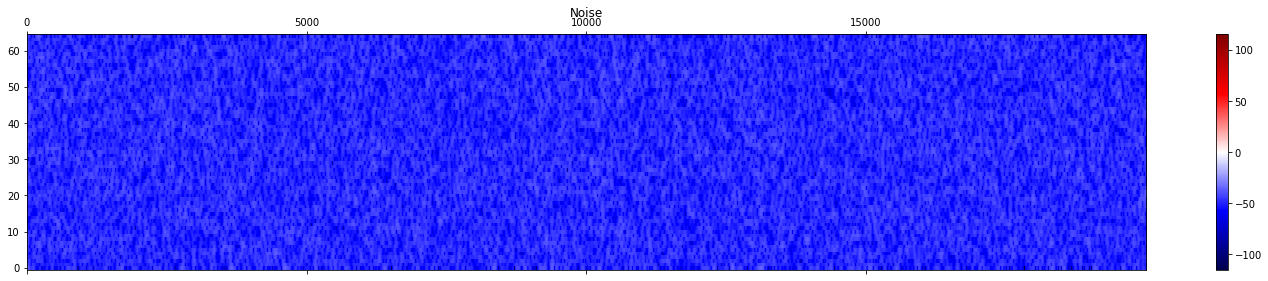

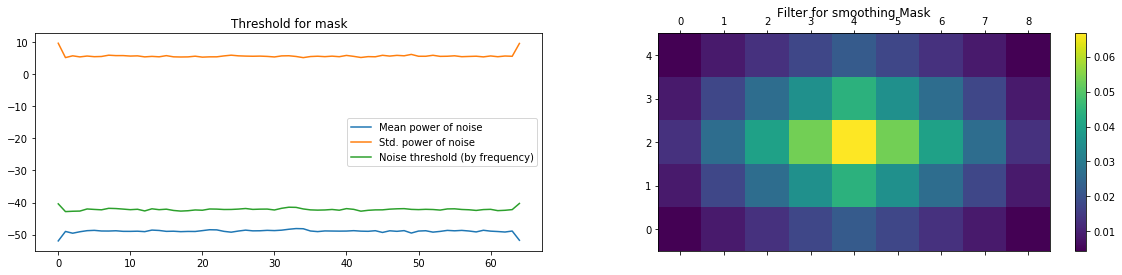

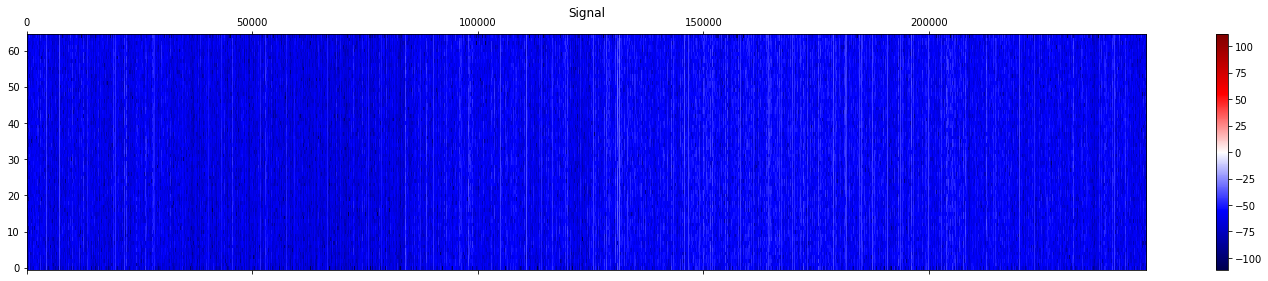

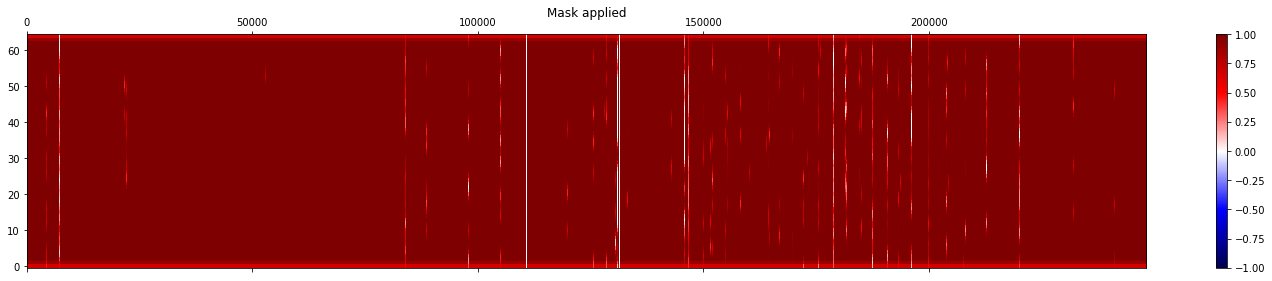

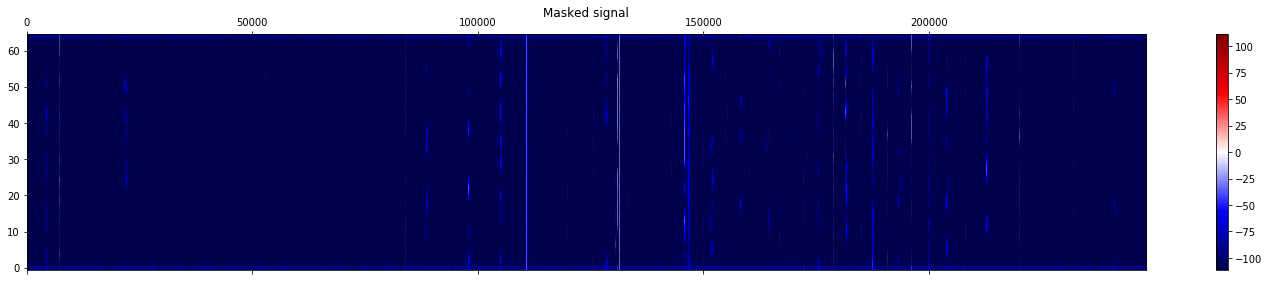

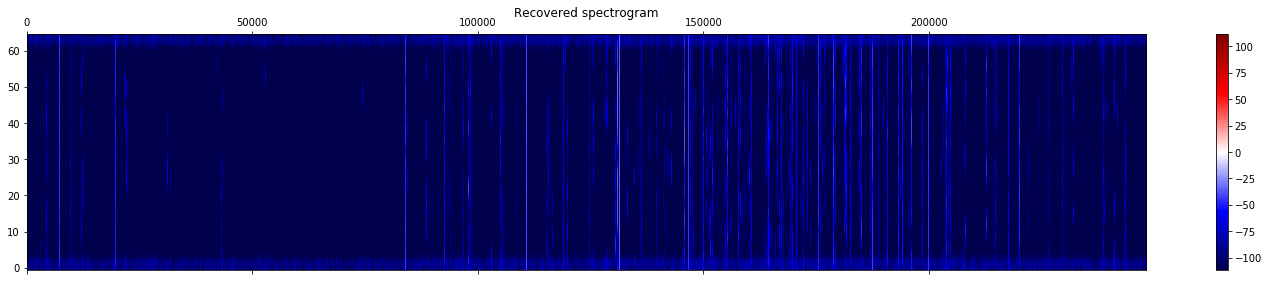

In [22]:
output = removeNoise(audio_clip=x.reshape(-1), noise_clip=xns, n_std_thresh=1.2, prop_decrease=1.0, 
                     n_fft=128, win_length=128, hop_length=1, 
                     verbose=True,visual=True)

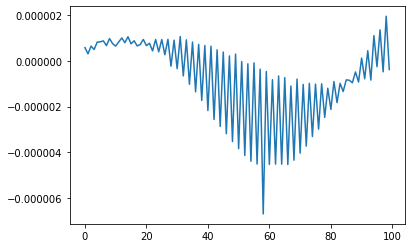

In [23]:
plot(output[10000:10100]);

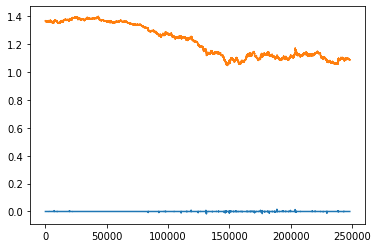

In [24]:
plot(output);
plot(datamatrix.close);

In [25]:
len(output), len(datamatrix.close), len(output) - len(datamatrix.close)

(248121, 248122, -1)